In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Check Data

df = pd.read_csv('co2Dataset.csv')
df

year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0    1958      3     1958.2027   315.70          314.43     -1 -9.99 -0.99
1    1958      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2    1958      5     1958.3699   317.51          314.71     -1 -9.99 -0.99
3    1958      6     1958.4548   317.24          315.14     -1 -9.99 -0.99
4    1958      7     1958.5370   315.86          315.18     -1 -9.99 -0.99
..    ...    ...           ...      ...             ...    ...   ...   ...
766  2022      1     2022.0417   418.19          417.82     29  0.73  0.26
767  2022      2     2022.1250   419.28          418.32     27  0.92  0.34
768  2022      3     2022.2083   418.81          417.34     30  0.78  0.27
769  2022      4     2022.2917   420.23          417.55     28  0.85  0.31
770  2022      5     2022.3750   420.99          417.57     30  0.76  0.27

[771 rows x 8 columns]

<AxesSubplot:title={'center':'Carbon Dioxide Levels'}, xlabel='Date', ylabel='Average'>

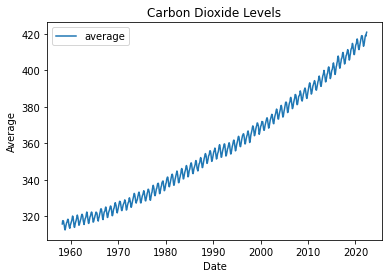

In [3]:
df.plot(x='decimal date', xlabel='Date', y='average', ylabel='Average', title='Carbon Dioxide Levels')

In [4]:
df.shape
total = df.shape[0]
total

771

In [5]:
# Check for stationarity

from statsmodels.tsa.stattools import adfuller
def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating it is non-stationary ")

In [6]:
adfuller_test(df['average'])

ADF Test Statistic : 5.088871396047054
p-value : 1.0
#Lags Used : 20
Number of Observations : 750
weak evidence against null hypothesis, indicating it is non-stationary 


In [7]:
adfuller_test(df['average'].diff(1).dropna())
# d = 1 makes data stationary

df['diff'] = df['average'].diff(1).dropna()

ADF Test Statistic : -5.240671578519135
p-value : 7.257862986890481e-06
#Lags Used : 20
Number of Observations : 749
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


C:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


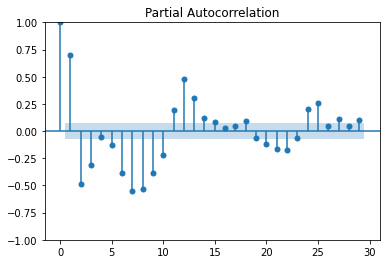

In [9]:
# Check acf/pacf plots for p and q values
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig1 = plot_pacf(df['diff'].dropna())

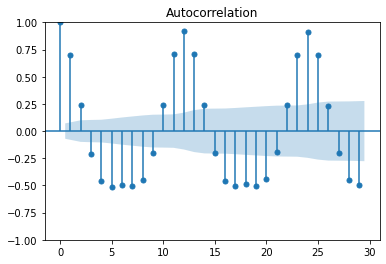

In [10]:
fig2 = plot_acf(df['diff'].dropna())

In [11]:
split = round(df['average'].shape[0]*.9)
split

694

In [12]:
dftrain = df['average'][:split]
dftest = df['average'][split:]

In [29]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(dftrain, order=(3,2,3))
modelfit = model.fit()
predict = modelfit.forecast(total-split)

C:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


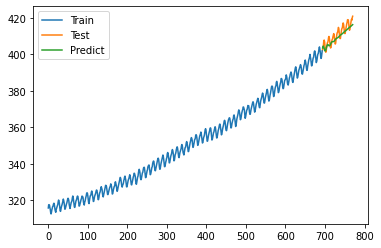

In [30]:
plt.plot(dftrain, label='Train')
plt.plot(dftest, label='Test')
plt.plot(predict, label='Predict')
plt.legend(loc='upper left')
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def eval_model(actual, predict):
    rmse = f'RMSE = {mean_squared_error(y_true=actual, y_pred=predict, squared=False):.2f}'
    mape = f'MAPE = {mean_absolute_percentage_error(y_true=actual, y_pred=predict):.2f}'
    mae = f'MAE = {mean_absolute_error(y_true=actual, y_pred=predict):.2f}'
    
    print(f'{rmse}\n{mape}\n{mae}')

In [32]:
eval_model(dftest,predict)

RMSE = 2.81
MAPE = 0.01
MAE = 2.32


In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.seasonal import seasonal_decompose

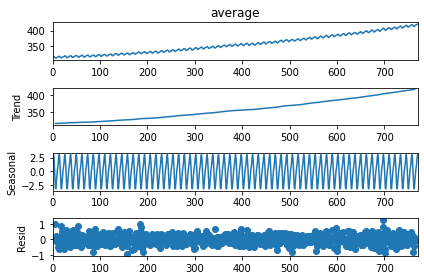

In [44]:
sdecomplot = seasonal_decompose(df['average'], period=12, model='additive').plot()

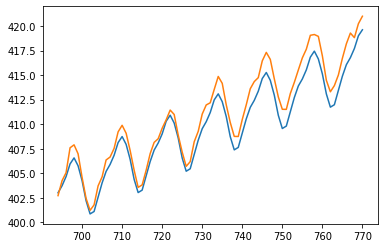

In [57]:
modelfit = HWES(dftrain, trend='add', seasonal='add', seasonal_periods=12).fit()
predict = modelfit.forecast(total-split)
plt.plot(predict)
plt.plot(dftest)
plt.show()

In [58]:
eval_model(dftest,predict)

RMSE = 1.38
MAPE = 0.00
MAE = 1.24


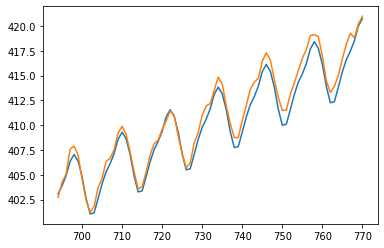

In [59]:
modelfit = HWES(dftrain, trend='mul', seasonal='mul', seasonal_periods=12).fit()
predict = modelfit.forecast(total-split)
plt.plot(predict)
plt.plot(dftest)
plt.show()

In [60]:
eval_model(dftest,predict)

RMSE = 0.92
MAPE = 0.00
MAE = 0.79
